##### scRNA-seq derived 5 cell types reference (scLM5)
- Neutrophils
- Monocytes
- B cells
- CD8T cells
- NK cells

In [1]:
Base_dir = 'C:/github/LiverDeconv' # cloning repository

import sys
sys.path.append(Base_dir)
import liver_deconv

import pandas as pd

***
##### 1. Reference preparation

In [2]:
# load data
df_mix = pd.read_csv(Base_dir+'/data/mix_processed.csv',index_col=0)
df_all = pd.read_csv('d:/datasource/Deconvolution/E-MTAB-8263/processed/lm10_mean_27998x332.csv',index_col=0)

target_cells = ["Neutrophil","Monocyte","B","CD8","NK"] # 5 cell types
use_samples = []
for t in df_all.columns.tolist():
    if t.split("_")[0] in target_cells:
        use_samples.append(t)
df_target = df_all[use_samples]
print(df_mix.shape)
display(df_mix.head())
print(df_target.shape)
display(df_target.head())

(11588, 57)


,ANIT_1,ANIT_2,ANIT_3,ANIT_4,APAP_1,APAP_11,APAP_2,APAP_4,APAP_6,APAP_8,...,MDA_8,TAA_1,TAA_3,TAA_6,TAA_7,TAA_8,GAL_2,GAL_4,GAL_7,GAL_8
0610005C13Rik,11.875867,12.148424,11.252824,12.411776,11.733585,11.068134,11.748217,11.856797,12.010466,11.216230,...,12.134986,10.641326,10.482294,10.242923,10.101400,9.562121,9.941478,8.431683,7.700966,8.962926
0610009B22Rik,8.734242,8.457720,8.184438,8.506085,7.542759,8.233699,8.699826,8.748106,8.434342,7.651400,...,8.247180,7.936489,8.039019,7.926510,7.985361,7.755954,8.767225,8.663929,8.546301,8.989601
0610010F05Rik,6.490900,6.421802,5.806085,6.462369,5.565017,6.059207,5.922221,5.990138,5.467135,5.755073,...,6.552560,6.950840,6.120020,6.206200,6.356350,6.086378,4.909432,6.207227,6.382519,6.357380
0610010K14Rik,8.564556,8.673014,8.348932,8.224936,9.066347,8.904317,8.386174,8.778923,8.426116,9.441442,...,8.122928,8.779766,9.291585,9.132055,9.200938,9.173803,9.273967,8.512630,8.407845,8.454941
0610012G03Rik,8.097187,7.933714,7.698964,7.900242,8.162186,7.959631,7.644485,7.770003,8.080504,8.389386,...,7.740478,8.486990,8.506687,7.844173,7.849986,7.853950,8.150181,8.108420,7.913200,8.247160


(27998, 5)


,Neutrophil,Monocyte,B,CD8,NK
ENSMUSG00000051951,0.0,0.0000,0.0,0.0,0.0
ENSMUSG00000089699,0.0,0.0000,0.0,0.0,0.0
ENSMUSG00000102343,0.0,0.0000,0.0,0.0,0.0
ENSMUSG00000025900,0.0,0.0002,0.0,0.0,0.0
ENSMUSG00000109048,0.0,0.0000,0.0,0.0,0.0


(11588, 57)
(27998, 5)
log2 conversion
quantile normalization
drop nan
narrowd gene number : 10914
signature genes : 106


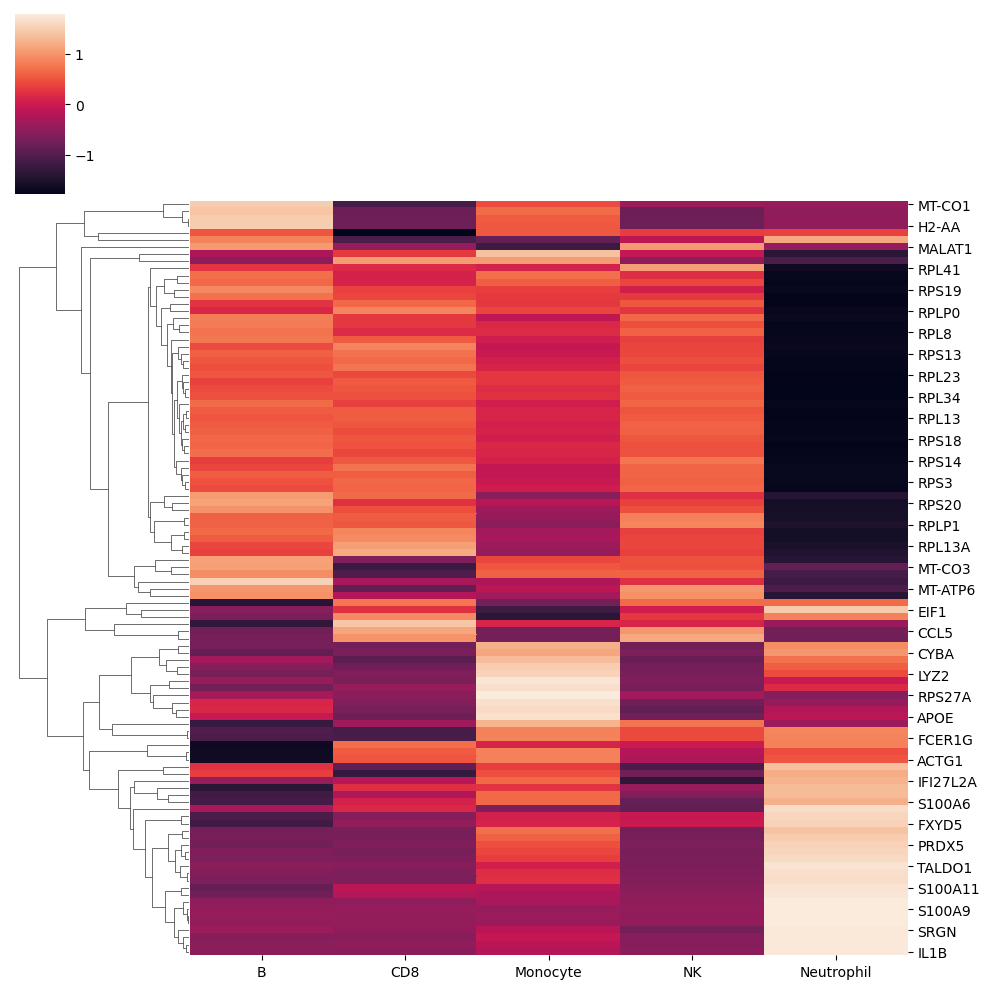

In [3]:
# %% create reference
dat = liver_deconv.LiverDeconv()
dat.set_data(df_mix=df_mix, df_all=df_target)
ann_df = pd.read_csv('c:/github/LiverDeconv/Data/raw/Mouse_stable2MouseMGI.csv')
dat.pre_processing(do_ann=True,ann_df=ann_df,do_log2=True,do_quantile=True,do_trimming=False,do_drop=True)
dat.narrow_intersec()
dat.create_ref(sep="_",number=50,limit_CV=10,limit_FC=1.5,log2=False,verbose=True,do_plot=True)

***
##### 2. Conduct deconvolution with Elastic Net

0 rows are removed
0 rows are removed
number of used genes = 106
fitting method : ElasticNet


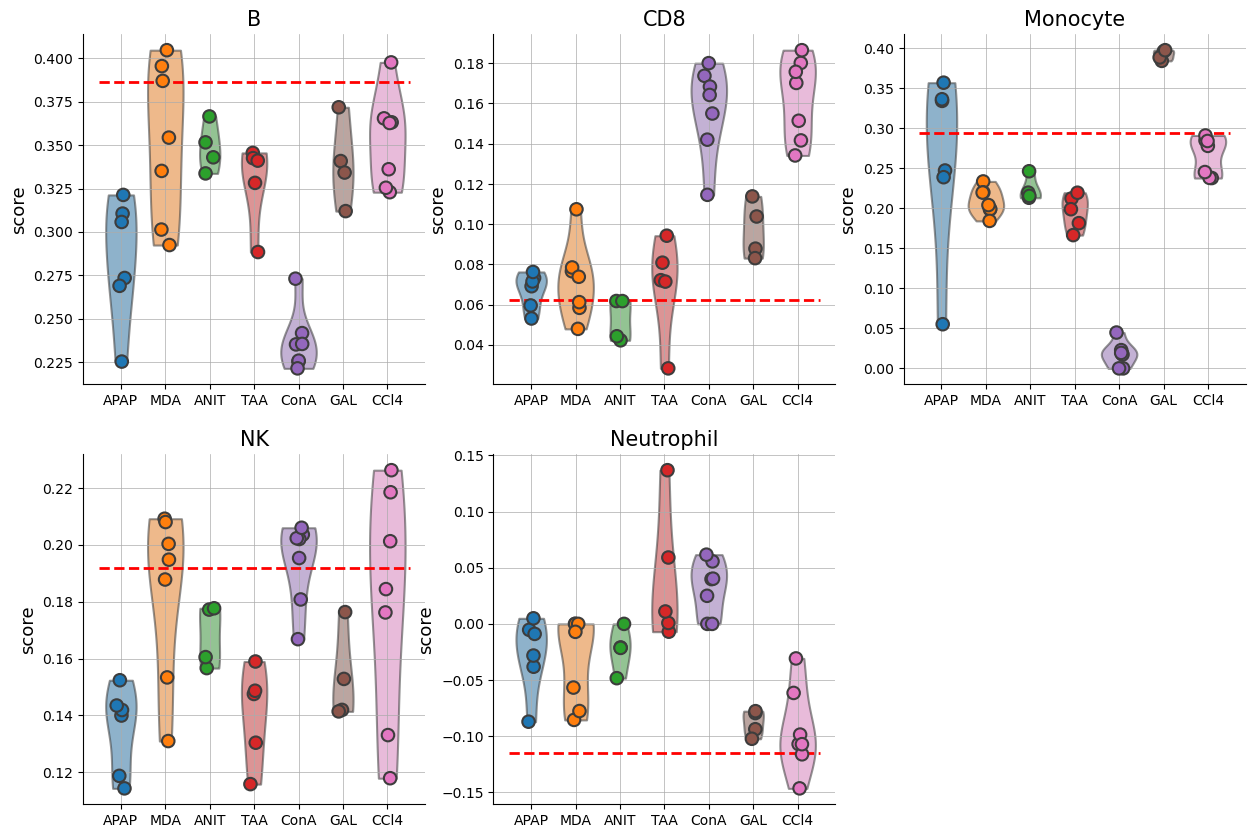

In [4]:
dat.do_fit(method="ElasticNet",alpha=1,l1_ratio=0.05)
dat.summarize(remove_list=["CIV_7","CIV_8","CIP_7","CIP_8"],
                  sort_index=["APAP","MDA","ANIT","TAA","ConA","GAL","CCl4"],
                  x_doc="",y_doc="score",ctrl="Ctrl",row_n=2,col_n=3,z_score=False)
res = dat.get_res()

***
##### 3. Validation with True values (measured by FACS)

standardz population control
original : 57
after removing : 53
standardz population control
----------


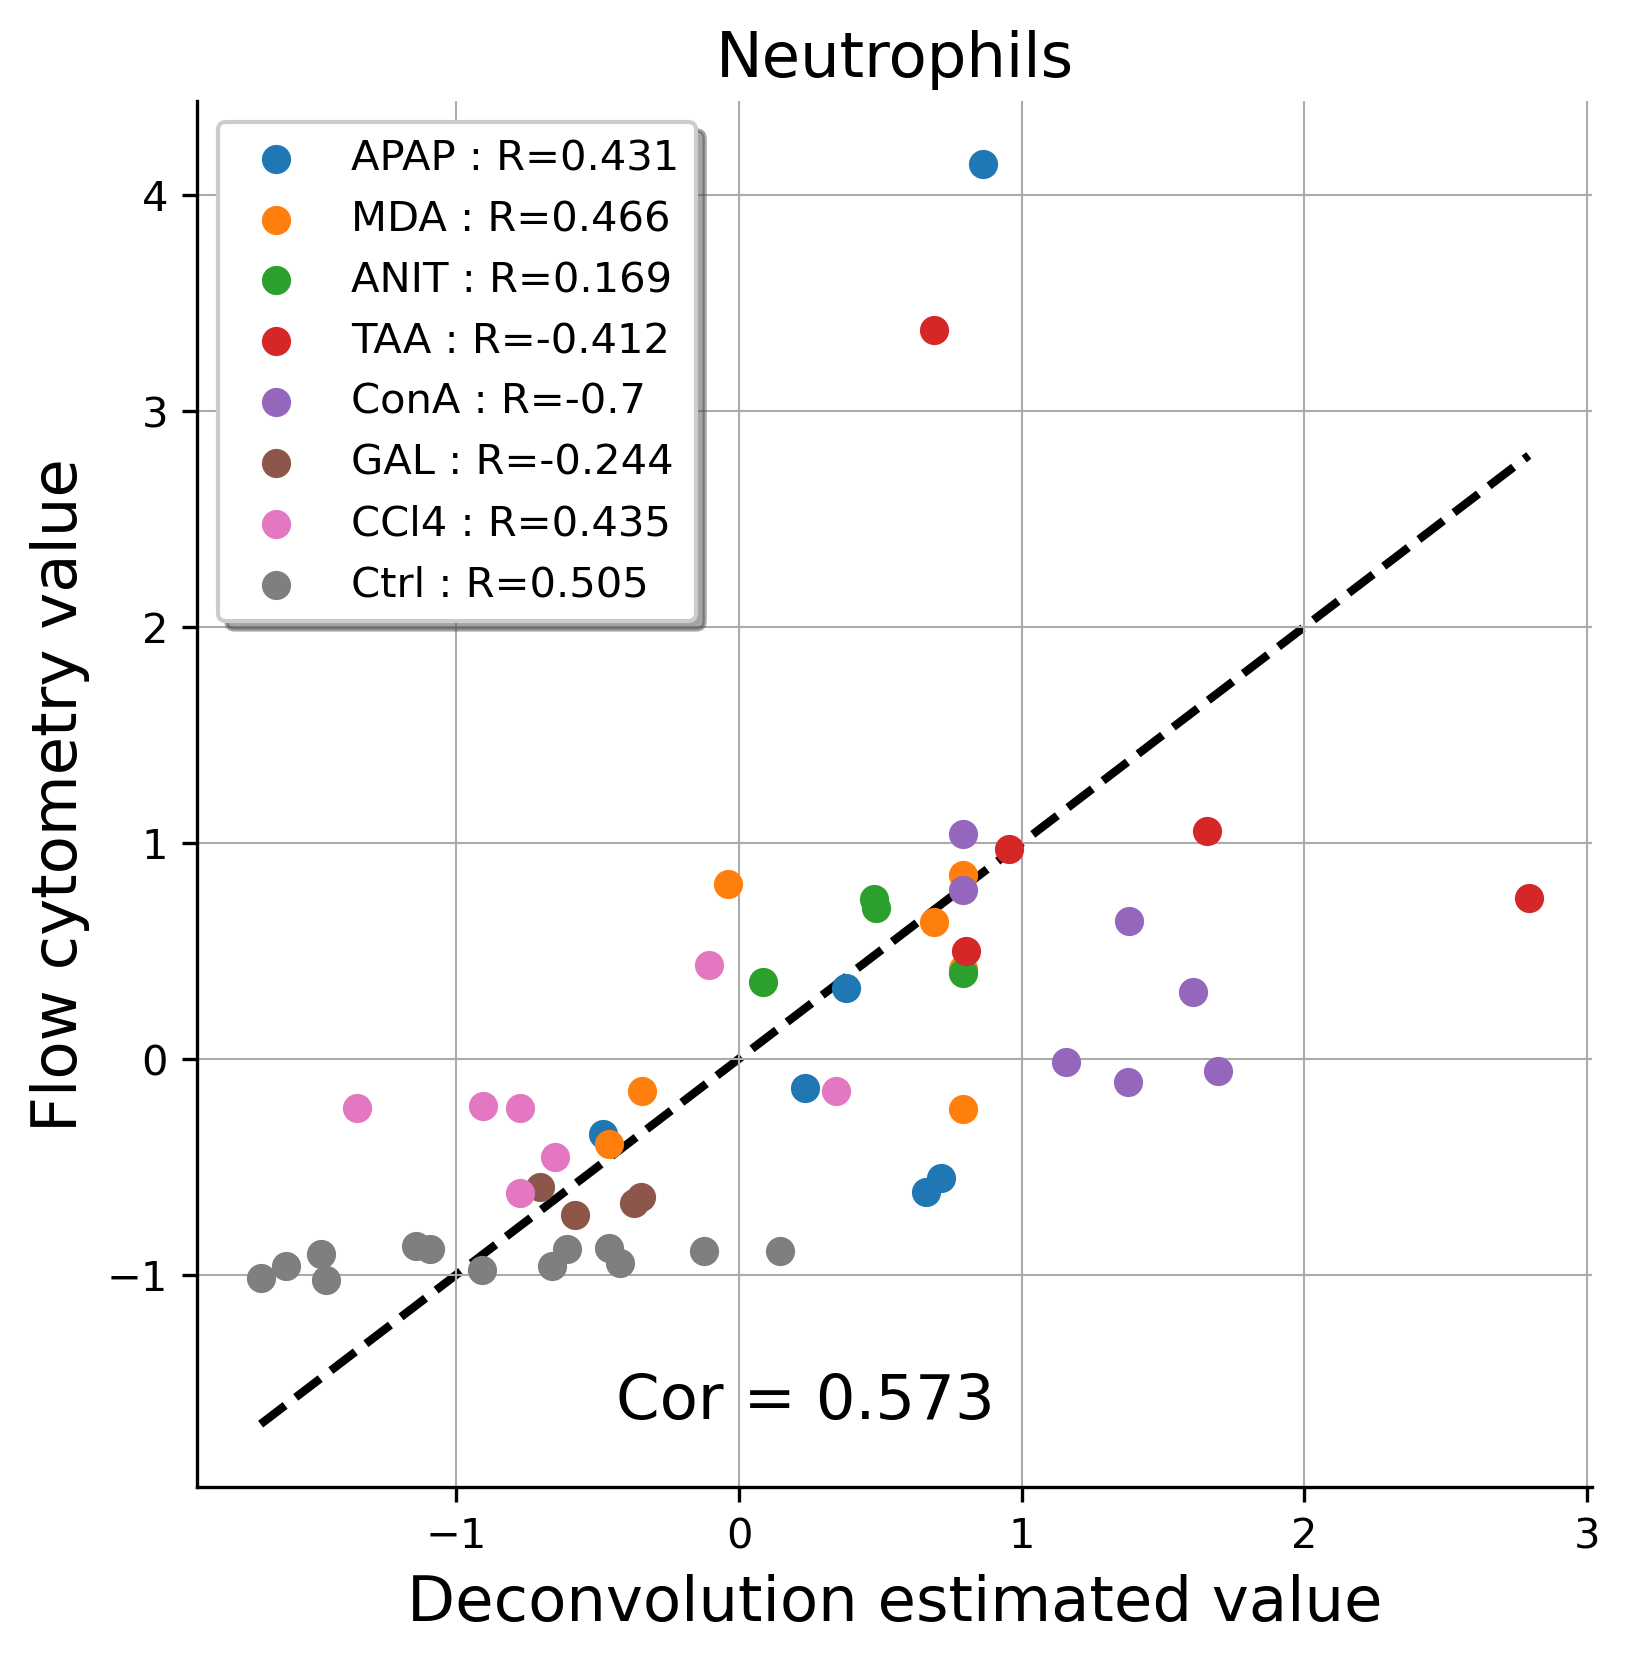

----------


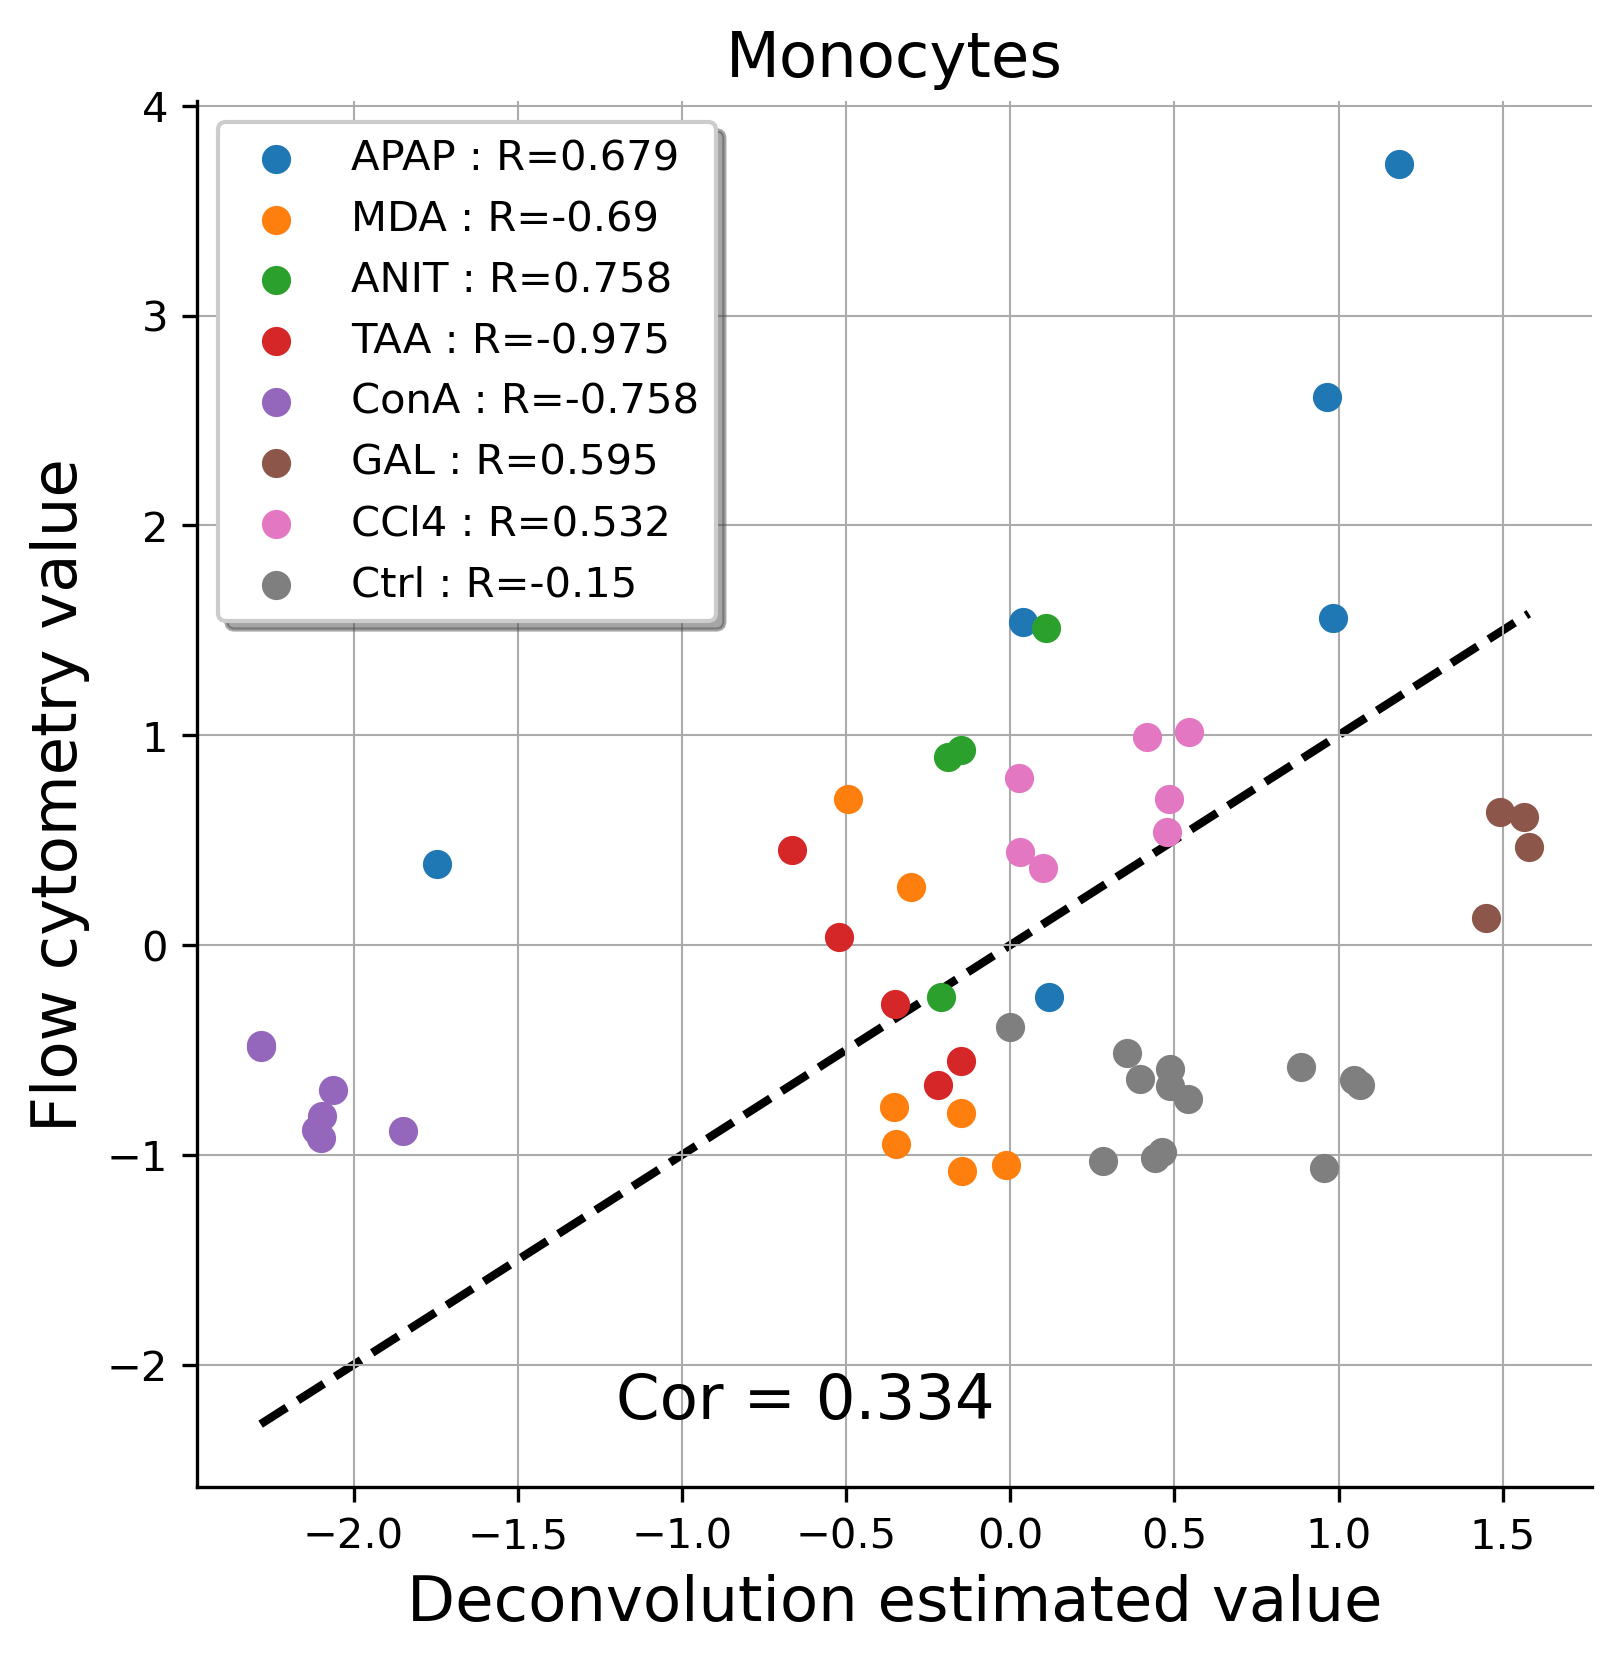

----------


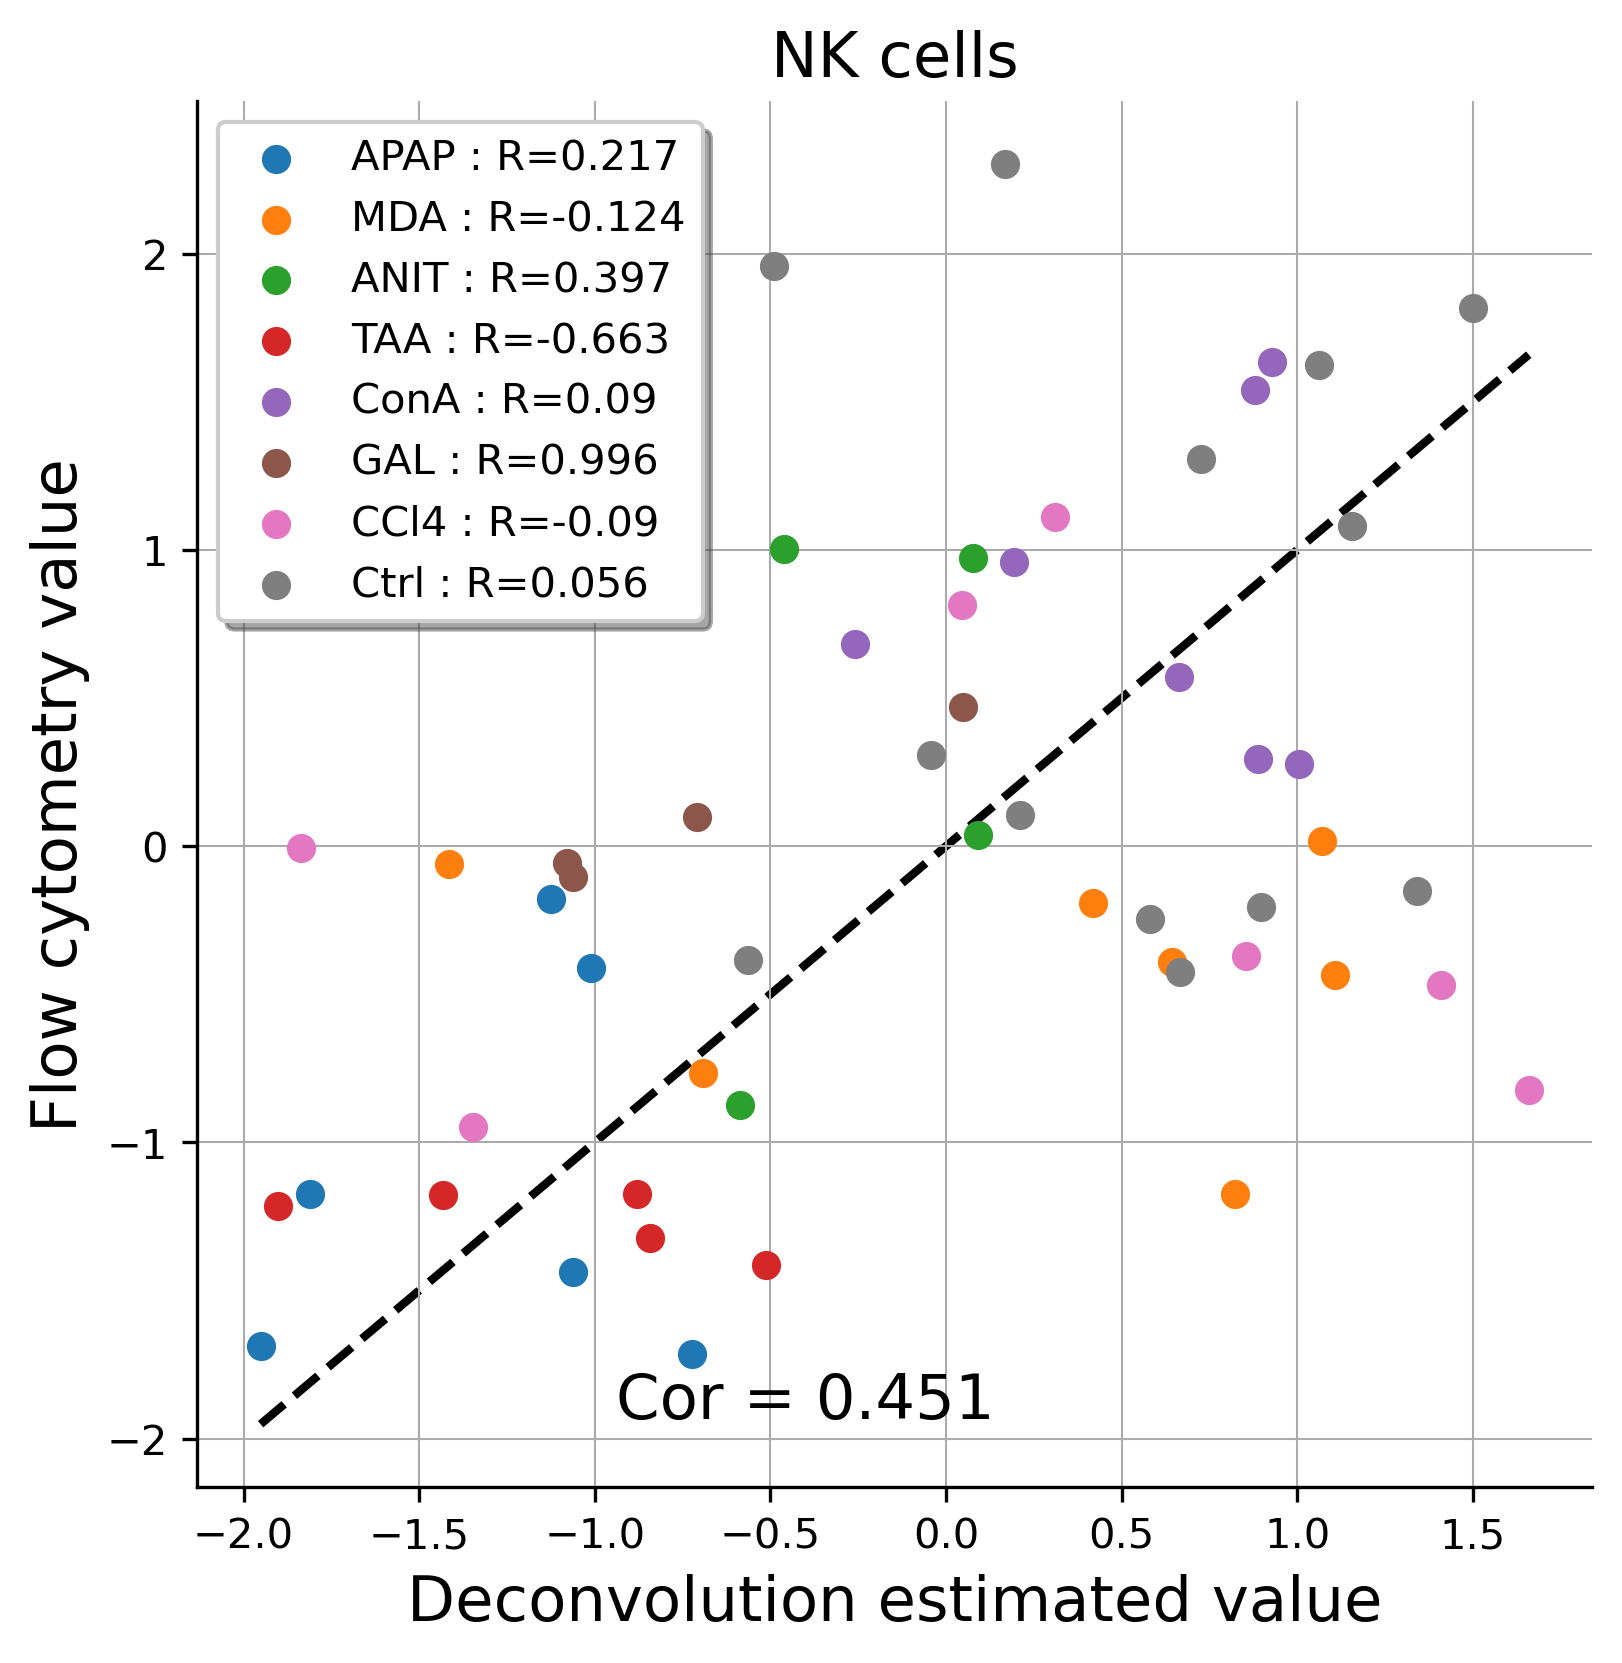

In [5]:
from Evaluation import evaluator

val_df = pd.read_csv('C:/github/LiverDeconv/Data/facs_true_population.csv',index_col=0)

ev = evaluator.Evaluator()
ev.set_deconv_res(res_df=res,z_score=True)
ev.remove_samples(remove_list=["CIV_7","CIV_8","CIP_7","CIP_8"])
ev.set_validation_ref(val_df=val_df)
ev.process_validation_ref(z_score=True)

ev.evaluate(dec_names=[["Neutrophil"]],
            val_names=[["Neutrophil"]],sort_index=["APAP","MDA","ANIT","TAA","ConA","GAL","CCl4","Ctrl"],title="Neutrophils",do_plot=True,simple=False,eval_all=False,dpi=300)
ev.evaluate(dec_names=[["Monocyte"]],
            val_names=[["Monocyte"]],sort_index=["APAP","MDA","ANIT","TAA","ConA","GAL","CCl4","Ctrl"],title="Monocytes",do_plot=True,simple=False,eval_all=False,dpi=300)
ev.evaluate(dec_names=[["NK"]],
            val_names=[["NK"]],sort_index=["APAP","MDA","ANIT","TAA","ConA","GAL","CCl4","Ctrl"],title="NK cells",do_plot=True,simple=False,eval_all=False,dpi=300)